In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

## Loading Dataset

In [183]:
dataframe = pd.read_csv('database.csv', na_values=[''])

## Ordering Columns

In [184]:
dataframe.columns.tolist()

['Unnamed: 0',
 'row_close',
 'levelCounter',
 'trial_set',
 'row_start',
 'time_secs',
 'ptcp',
 'feedbackType',
 'correctCounter',
 'Change Flag']

In [185]:
new_order = ['ptcp',
             'trial_set',
             'levelCounter',
             #'row_start',
             #'row_close',
             'time_secs',
             'feedbackType',
             'correctCounter'
             ]

In [186]:
work_df = dataframe[new_order]
work_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ptcp            2362 non-null   object 
 1   trial_set       2362 non-null   int64  
 2   levelCounter    2358 non-null   float64
 3   time_secs       2341 non-null   float64
 4   feedbackType    2358 non-null   object 
 5   correctCounter  2193 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 110.8+ KB


I will tranfor 'ptcp' and 'trial set' in categorical values because the represent the participants, the stage at which the experiment developed and the feedback category. Not really numerical values.

In [187]:
work_df.loc[:, 'ptcp'] = work_df['ptcp'].astype('category')
work_df.loc[:, 'trial_set'] = work_df['trial_set'].astype('category')
work_df.loc[:, 'feedbackType'] = work_df['feedbackType'].astype('category')



## Data Validation

man step of validation (such as varaible type, formating, uniqueness, are already performed in the construction of the data set). Nonetheless this second layer is for the final result. First we need to watch if after the tranformations of the raw-data all conditions look as expected

1.- We expect 22 participants and 36 trials per set. 

In [188]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
levels_per_set_per_participant = work_df.groupby(['ptcp', 'trial_set'], observed=True)['levelCounter'].count()

# Display the result
print("\nNumber of levels per set per participant:")
print(levels_per_set_per_participant)


Number of levels per set per participant:
ptcp    trial_set
tsvr06  1            36
        2            36
        3            36
tsvr07  1            36
        2            36
                     ..
tsvr26  2            36
        3            35
tsvr27  1            36
        2            36
        3            35
Name: levelCounter, Length: 66, dtype: int64


Due to a failure in the excecution of the program while taking the experiment; the last level (35) is missing for most participants in set 3. I think we need to remove it for all participants in all sets since we don' want to umbalanced the results. 

In [189]:
# removing 
work_df2 =  work_df[work_df['levelCounter']<35]

After the removal we have the number of not exactly as designed. We need to check that even if the numbre of trials per condition is not exactly the same the 

In [190]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
check_per_level = work_df2.groupby(['levelCounter','feedbackType']).count()
check_per_level = check_per_level.reset_index()
check_per_level['deviation']= 22-check_per_level['ptcp']
print(check_per_level)



     levelCounter feedbackType  ptcp  trial_set  time_secs  correctCounter  \
0             0.0    congruent    21         21         21              21   
1             0.0  incongruent    22         22         22              16   
2             0.0         none    23         23         23              22   
3             1.0    congruent    23         23         23              20   
4             1.0  incongruent    23         23         23              22   
..            ...          ...   ...        ...        ...             ...   
100          33.0  incongruent    21         21         21              18   
101          33.0         none    25         25         25              23   
102          34.0    congruent    26         26         26              22   
103          34.0  incongruent    19         19         19              16   
104          34.0         none    21         21         21              21   

     deviation  
0            1  
1            0  
2           

The feedback Types are not exactly splited into three equal groups, there is a deviation wich I will look into at a participant level.  Next, we will t-test if this deviation is isgnificanttly different from 0. 
For every level we expect to see 22 participants in each condition, this is our ideal scenario. So for example, for level 1 we expect to have 22 partipants in case "congruent", 22 in case "incongruent" and 22 in case "none". Since this is not the case I will see how much the diviate form the ideal case (22 - x) and if this is statiscally different from 0. 

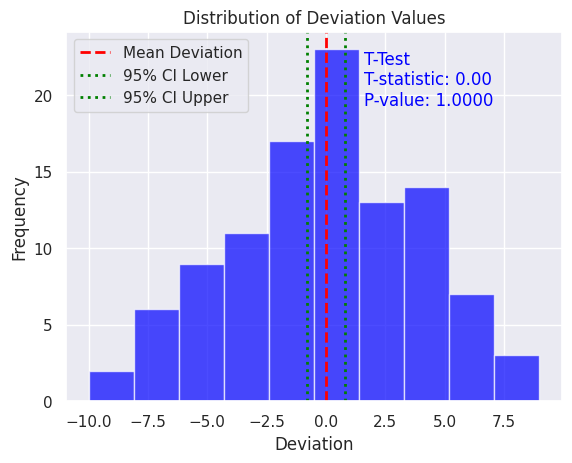

In [191]:

# Assuming your DataFrame is named check_per_level
deviation_values = check_per_level['deviation']

# Create the histogram
plt.hist(deviation_values, bins=10, color='blue', alpha=0.7)
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Deviation Values')

# Calculate the mean and standard error of the mean (SEM)
mean_deviation = np.mean(deviation_values)
sem_deviation = np.std(deviation_values) / np.sqrt(len(deviation_values))

# Calculate the 95% confidence interval
ci_lower = mean_deviation - 1.96 * sem_deviation
ci_upper = mean_deviation + 1.96 * sem_deviation

# Perform a t-test (assuming a population mean of 0)
t_stat, p_value = stats.ttest_1samp(deviation_values, 0)

# Add the confidence interval and t-test result to the plot
plt.axvline(mean_deviation, color='red', linestyle='dashed', linewidth=2, label='Mean Deviation')
plt.axvline(ci_lower, color='green', linestyle='dotted', linewidth=2, label='95% CI Lower')
plt.axvline(ci_upper, color='green', linestyle='dotted', linewidth=2, label='95% CI Upper')

# Add t-test result to the plot
plt.annotate(f'T-Test\nT-statistic: {t_stat:.2f}\nP-value: {p_value:.4f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

plt.legend(loc='upper left')
plt.show()


This shows that the median deviation of ptcp per category is 0. Which supports the argument that after removing level 35 of all the sample feedbacktype remains a legitimate independent variable. 

Now at a participantt point of view. We expect for each participantto have 36 levels pero condition. This is not now exactly the case so we creat a deviation varaible (36- x). The results look osmething like the following:

In [192]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
check_per_ptcp = work_df2.groupby(['ptcp','feedbackType']).count()
check_per_ptcp = check_per_ptcp.reset_index()
check_per_ptcp['deviation']= 35-check_per_ptcp['trial_set']
print(check_per_ptcp)

      ptcp feedbackType  trial_set  levelCounter  time_secs  correctCounter  \
0   tsvr06    congruent         35            35         35              33   
1   tsvr06  incongruent         34            34         34              31   
2   tsvr06         none         36            36         36              35   
3   tsvr07    congruent         35            35         35              32   
4   tsvr07  incongruent         33            33         33              30   
..     ...          ...        ...           ...        ...             ...   
61  tsvr26  incongruent         35            35         35              32   
62  tsvr26         none         35            35         35              33   
63  tsvr27    congruent         35            35         35              35   
64  tsvr27  incongruent         34            34         34              33   
65  tsvr27         none         36            36         36              36   

    deviation  
0           0  
1           1  
2  

I proceed to run a t.test to see if deviation is something different from 0. Its not .

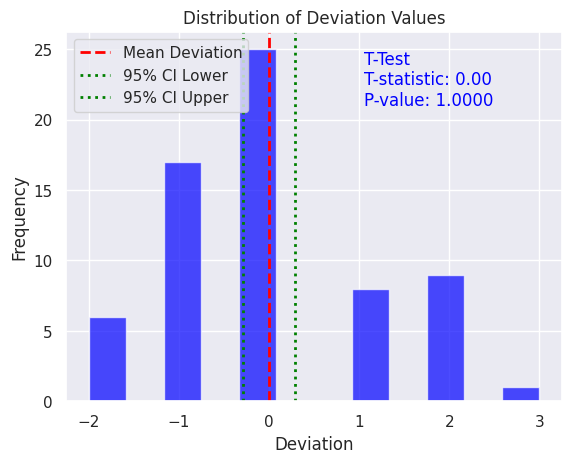

In [193]:
# Assuming your DataFrame is named check_per_level
deviation_values = check_per_ptcp['deviation']

# Create the histogram
plt.hist(deviation_values, bins=12, color='blue', alpha=0.7)
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Deviation Values')

# Calculate the mean and standard error of the mean (SEM)
mean_deviation = np.mean(deviation_values)
sem_deviation = np.std(deviation_values) / np.sqrt(len(deviation_values))

# Calculate the 95% confidence interval
ci_lower = mean_deviation - 1.96 * sem_deviation
ci_upper = mean_deviation + 1.96 * sem_deviation

# Perform a t-test (assuming a population mean of 0)
t_stat, p_value = stats.ttest_1samp(deviation_values, 0)

# Add the confidence interval and t-test result to the plot
plt.axvline(mean_deviation, color='red', linestyle='dashed', linewidth=2, label='Mean Deviation')
plt.axvline(ci_lower, color='green', linestyle='dotted', linewidth=2, label='95% CI Lower')
plt.axvline(ci_upper, color='green', linestyle='dotted', linewidth=2, label='95% CI Upper')

# Add t-test result to the plot
plt.annotate(f'T-Test\nT-statistic: {t_stat:.2f}\nP-value: {p_value:.4f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

plt.legend(loc='upper left')
plt.show()

## Data Cleaning 

In [194]:
work_df = work_df2
work_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2310 entries, 0 to 2360
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ptcp            2310 non-null   object  
 1   trial_set       2310 non-null   category
 2   levelCounter    2310 non-null   float64 
 3   time_secs       2310 non-null   float64 
 4   feedbackType    2310 non-null   object  
 5   correctCounter  2145 non-null   float64 
dtypes: category(1), float64(3), object(2)
memory usage: 110.7+ KB


After the removal of the levels 35. There are 2310 observations. 

Now lets make a flag that flags with one when the trail is a mistake and with 0 when the answer was correct. 

In [195]:
work_df['mistake_flag'] = work_df['correctCounter'].apply(lambda x: 1 if pd.isna(x) else 0)

Checking Correlation of the numeric variables. 


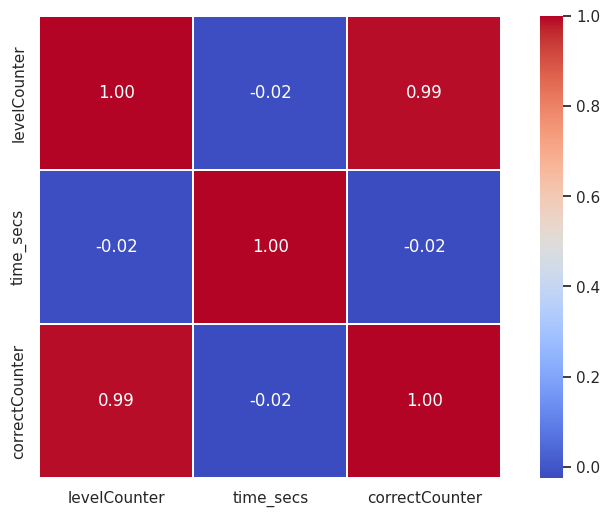

In [196]:
# Checking correlation between variables. 

numeric_df = work_df[['levelCounter','time_secs', 'correctCounter']]

fig = plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
sns.heatmap(numeric_df.corr(), cbar=True, annot=True, square=True,\
                 fmt='.2f',
                 annot_kws={'size': 12}, yticklabels=numeric_df.columns,\
                 xticklabels=numeric_df.columns, cmap = 'coolwarm',lw = .1)
plt.show()

